In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import seaborn as sns
from pathlib import Path
import os
from os.path import join
import re
import math
from collections import OrderedDict
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.tsa.seasonal import STL
from sklearn.ensemble import RandomForestClassifier
# from sklearn.cluster import DBSCAN
from pyod.models.abod import ABOD
from pyod.models.iforest import IForest
from pyod.models.lof import LOF
from pyod.models.rod import ROD

from sklearn.utils import check_random_state
from sklearn.model_selection import ParameterSampler

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

import shap
import pickle
from joblib import Parallel, delayed

In [2]:
import warnings
from sklearn.ensemble import IsolationForest

warnings.filterwarnings("ignore", message="X has feature names, but IsolationForest was fitted without feature names")

# Coleta de Dados

In [3]:
MODULE_PATH = Path().absolute().parent
DATA_PATH = join(MODULE_PATH, "sources/processed")

In [4]:
complete_data = pd.read_csv(join(DATA_PATH, "complete_data_ground_truth.csv"))

In [5]:
complete_data["data"] = pd.to_datetime(complete_data["data"])

In [6]:
complete_data = complete_data[complete_data.columns[:10].to_list() + ["total_outliers"]]

In [7]:
complete_data.head()

,ano,mes,data,precipitacao_total_media,temperatura_bulbo_hora_media,temperatura_orvalho_hora_media,umidade_rel_hora_media,categoria_El Ninõ,categoria_La Ninã,categoria_Neutro,total_outliers
0,2009,1,2009-01-01,0.149600,25.187439,20.299029,76.026835,0,1,0,0
1,2009,1,2009-01-02,0.305735,24.722086,20.084109,77.689743,0,1,0,0
2,2009,1,2009-01-03,0.434014,24.058518,19.749311,78.933681,0,1,0,1
3,2009,1,2009-01-04,0.245052,23.368056,18.715145,77.340627,0,1,0,0
4,2009,1,2009-01-05,0.201583,23.101135,17.945004,75.597683,0,1,0,0


# Pré-Processamento

## Definição do Pipeline

In [8]:
feature_cols = complete_data.columns.tolist()[3:10]
numerical_cols = feature_cols[:-3]
categorical_cols = feature_cols[-3:]

In [56]:
def split_data(
    df: pd.DataFrame,
    year_cap: int = 2024,
    train_size: float = None):

    df = df.copy()

    if train_size is not None:
        df_train = df.iloc[:int(len(df)* 0.7)]
        df_test = df.iloc[int(len(df)* 0.7):]
        return df_train, df_test
    
    df_train = df[df["ano"] < year_cap]
    df_test = df[df["ano"] == year_cap]
    
    return df_train, df_test

In [10]:
def scale_data(
    df: pd.DataFrame, 
    columns: list[str]):

    df = df.copy()  
    
    scaler = StandardScaler()
    df[columns] = scaler.fit_transform(df[columns])
        
    return df

In [11]:
def create_residual_df(
    df: pd.DataFrame,
    numerical_cols: list[str],
    seasonal_period: int = 7):

    residual_df = df.copy()

    for col in numerical_cols:
        feature_decomposition = STL(residual_df[col], period=seasonal_period).fit()
        residual_df[col] = residual_df[col] - feature_decomposition.seasonal.values

    return residual_df

In [12]:
def create_ground_truth(
    df: pd.DataFrame,
    numerical_cols: list[str]):

    scaled_df = scale_data(df=df[numerical_cols], columns=numerical_cols)
    for col in scaled_df.columns:
        scaled_df[f'{col}_outlier'] = ((scaled_df[col] > 2) | (scaled_df[col] < -2))
        scaled_df[f'{col}_outlier'] = scaled_df[f'{col}_outlier'].astype(int)
    
    scaled_df["total_outliers"] = ((scaled_df > 2) | (scaled_df < -2)).sum(axis=1)

    ground_truth_cols = [col for col in scaled_df.columns.tolist() if col.endswith('_outlier') or col == 'total_outliers']
    ground_truth_data = scaled_df[ground_truth_cols]

    df[ground_truth_cols] = ground_truth_data

    return df

In [58]:
def preprocess_pipeline(
    df: pd.DataFrame,
    numerical_cols: list[str],
    normalize_data: bool = False,
    remove_seasonality: bool = False,
    seasonal_period: int = 7,
    year_cap: int = 2024,
    train_size: float = None,
    add_ground_truth: bool = False):

    df = df.copy()

    df_train, df_test = split_data(
        df=df, 
        year_cap=year_cap,
        train_size=train_size)
    if add_ground_truth:
        df_train = create_ground_truth(df=df_train, numerical_cols=numerical_cols)
        df_test = create_ground_truth(df=df_test, numerical_cols=numerical_cols)

    if remove_seasonality:
        df_train = create_residual_df(
            df=df_train, 
            numerical_cols=numerical_cols,
            seasonal_period=seasonal_period)

        df_test = create_residual_df(
            df=df_test, 
            numerical_cols=numerical_cols,
            seasonal_period=seasonal_period)
        
    if normalize_data:
        df_train = scale_data(df=df_train, columns=numerical_cols)
        df_test = scale_data(df=df_test, columns=numerical_cols)
    
    return df_train, df_test

In [59]:
df_train, df_test = preprocess_pipeline(
    df=complete_data,
    numerical_cols=numerical_cols,
    normalize_data=True,
    remove_seasonality=True,
    seasonal_period=7,
    train_size=0.7,
    add_ground_truth=False
)

In [60]:
df_train.head()

,ano,mes,data,precipitacao_total_media,temperatura_bulbo_hora_media,temperatura_orvalho_hora_media,umidade_rel_hora_media,categoria_El Ninõ,categoria_La Ninã,categoria_Neutro,total_outliers
0,2009,1,2009-01-01,0.564379,0.472152,0.742392,0.629090,0,1,0,0
1,2009,1,2009-01-02,0.616107,0.457873,0.615668,0.464524,0,1,0,0
2,2009,1,2009-01-03,0.897630,0.332724,0.497421,0.430966,0,1,0,1
3,2009,1,2009-01-04,0.207865,0.205130,0.407617,0.388291,0,1,0,0
4,2009,1,2009-01-05,0.702311,0.043536,0.359761,0.532807,0,1,0,0


In [62]:
df_train.shape

(4090, 11)

In [61]:
df_test.head()

,ano,mes,data,precipitacao_total_media,temperatura_bulbo_hora_media,temperatura_orvalho_hora_media,umidade_rel_hora_media,categoria_El Ninõ,categoria_La Ninã,categoria_Neutro,total_outliers
4090,2020,3,2020-03-14,0.210127,1.282971,1.086948,0.279428,0,0,1,0
4091,2020,3,2020-03-15,1.162376,1.035762,1.083931,0.558107,0,0,1,0
4092,2020,3,2020-03-16,0.840286,0.879772,1.107924,0.793590,0,0,1,0
4093,2020,3,2020-03-17,0.363189,0.916947,1.141200,0.798208,0,0,1,0
4094,2020,3,2020-03-18,1.139066,0.858532,1.133967,0.877431,0,0,1,0


In [63]:
df_test.shape

(1754, 11)

# Fine Tuning

In [66]:
def evaluate_model(model, X, y_true):
    y_pred = model.predict(X)

    return f1_score(y_true, y_pred)

In [67]:
def randomized_fine_tune_model(
    model_class: object, 
    param_distributions: dict, 
    X_train: pd.DataFrame, 
    X_test: pd.DataFrame, 
    y_test: pd.Series, 
    n_iter: int = 10, 
    n_jobs: int =-1, 
    random_state: int = None):
    
    rng = check_random_state(random_state)
    sampled_params = list(ParameterSampler(param_distributions, n_iter=n_iter, random_state=rng))

    def train_and_evaluate(params):
        try:
            model = model_class(**params).fit(X_train) 
            score = evaluate_model(model, X_test, y_test) 
            return score, params, model
        except Exception as e:
            print(f"Erro com parâmetros {params}: {e}")
            return -np.inf, params, None

    results = Parallel(n_jobs=n_jobs)(
        delayed(train_and_evaluate)(params) for params in sampled_params
    )

    best_result = max(results, key=lambda x: x[0])
    best_score, best_params, best_model = best_result
    return best_model, best_params, best_score


In [68]:
param_distributions = {
    ABOD: {
        'n_neighbors': [5, 10, 20, 50, 100],
        'method': ['fast']
    },
    IForest: {
        'n_estimators': [50, 100, 200, 300, 500],
        'max_samples': ['auto', 0.6, 0.8],
        'contamination': [0.05, 0.1, 0.15],
        'bootstrap': [False, True],
        'behaviour': ['old', 'new']
    },
    LOF: {
        'n_neighbors': [5, 10, 20, 50],
        'contamination': [0.05, 0.1, 0.15],
        'leaf_size': [30, 60, 90],
        'p': [1, 2]
    },
    ROD: {
        'contamination': [0.05, 0.1, 0.15, 0.2, 0.3]
    }
}


In [20]:
preprocess_parameters = [
    (True, True),
    (False, False),
    (True, False),
    (False, True)
]

In [32]:
results_dict = {}
for normalize_data, remove_seasonality in preprocess_parameters:
    df_train, df_test = preprocess_pipeline(
        df=complete_data,
        numerical_cols=numerical_cols,
        normalize_data=normalize_data,
        remove_seasonality=remove_seasonality,
        seasonal_period=7,
        year_cap=2024,
        add_ground_truth=False
    )

    test_labels = np.where(df_test["total_outliers"] > 0, 1, 0)

    for model_cls, params in param_distributions.items():
        best_model, best_params, best_score = randomized_fine_tune_model(
            model_class=model_cls, 
            param_distributions=params, 
            X_train=df_train[feature_cols], 
            X_test=df_test[feature_cols], 
            y_test=test_labels, 
            n_iter=20, 
            n_jobs=-1, 
            random_state=42
        )

        results_dict[model_cls.__name__] = {
            'model': best_model,
            'params': best_params,
            'score': best_score,
            'normalize_data': normalize_data,
            'remove_seasonality': remove_seasonality
        }

d:\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 10 is smaller than n_iter=20. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


KeyboardInterrupt: 

In [27]:
with open(f'{MODULE_PATH}/explorations/artifacts/fine_tuning_results.pkl', 'wb') as f:
    pickle.dump(results_dict, f)

In [21]:
with open(f'{MODULE_PATH}/explorations/artifacts/fine_tuning_results.pkl', 'rb') as f:
    results_dict = pickle.load(f)

In [ ]:
results_dict

{'ABOD': {'model': ABOD(contamination=0.1, method='fast', n_neighbors=10),
  'params': {'n_neighbors': 10},
  'score': 0.6036363636363636,
  'normalize_data': False,
  'remove_seasonality': True},
 'IForest': {'model': IForest(behaviour='old', bootstrap=True, contamination=0.15, max_features=1.0,
      max_samples=0.8, n_estimators=100, n_jobs=1, random_state=None,
      verbose=0),
  'params': {'n_estimators': 100,
   'max_samples': 0.8,
   'contamination': 0.15,
   'bootstrap': True},
  'score': 0.7914110429447853,
  'normalize_data': False,
  'remove_seasonality': True},
 'LOF': {'model': LOF(algorithm='auto', contamination=0.15, leaf_size=30, metric='minkowski',
    metric_params=None, n_jobs=1, n_neighbors=20, novelty=True, p=2),
  'params': {'n_neighbors': 20, 'contamination': 0.15},
  'score': 0.6996699669966997,
  'normalize_data': False,
  'remove_seasonality': True},
 'ROD': {'model': ROD(contamination=0.15, parallel_execution=False),
  'params': {'contamination': 0.15},
  's

In [28]:
results_dict["IForest"]

{'model': IForest(behaviour='old', bootstrap=True, contamination=0.15, max_features=1.0,
     max_samples=0.8, n_estimators=100, n_jobs=1, random_state=None,
     verbose=0),
 'params': {'n_estimators': 100,
  'max_samples': 0.8,
  'contamination': 0.15,
  'bootstrap': True},
 'score': 0.7914110429447853,
 'normalize_data': False,
 'remove_seasonality': True}

# Treinamento o Melhor Modelo

In [25]:
def fit_anomaly_detector(
    train_data: pd.DataFrame,
    model: object,
    params: dict = None):

    if params is not None:
        model = model(**params).fit(train_data)
    else:
        model = model().fit(train_data)

    if hasattr(model, "feature_importances_"):
        feature_importances = pd.DataFrame(
            model.feature_importances_,
            index=train_data.columns,
            columns=["importancia"]).sort_values("importancia", ascending=False)
    else:
        clf_model = RandomForestClassifier().fit(
            train_data, model.labels_)

        feature_importances = pd.DataFrame(
            clf_model.feature_importances_,
            index=train_data.columns,
            columns=["importancia"]).sort_values("importancia", ascending=False)
    
    return model, feature_importances

In [29]:
best_model_params = results_dict["IForest"]

df_train, df_test = preprocess_pipeline(
    df=complete_data,
    numerical_cols=numerical_cols,
    normalize_data=best_model_params["normalize_data"],
    remove_seasonality=best_model_params["remove_seasonality"],
    seasonal_period=7,
    year_cap=2024,
    add_ground_truth=False
)

iforest_model, iforest_feature_importances = fit_anomaly_detector(
    train_data=df_train[feature_cols],
    model=IForest,
    params=best_model_params["params"]
)

# Avaliação de Resultados

In [30]:
def anomaly_detection_report(
    y_true: pd.Series,
    y_pred: pd.Series):

    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    precision = precision_score(y_true=y_true, y_pred=y_pred)
    recall = recall_score(y_true=y_true, y_pred=y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred)
    roc_auc = roc_auc_score(y_true=y_true, y_score=y_pred)
    
    return pd.DataFrame(
        {
            "accuracy": [accuracy],
            "precision": [precision],
            "recall": [recall],
            "f1": [f1],
            "roc_auc": [roc_auc]
        }
    )

In [31]:
train_labels = np.where(df_train["total_outliers"] > 0, 1, 0)
test_labels = np.where(df_test["total_outliers"] > 0, 1, 0)

train_pred = iforest_model.labels_

test_pred = iforest_model.predict(df_test[feature_cols])
test_anomaly_scores = iforest_model.decision_function(df_test[feature_cols])

train_report = anomaly_detection_report(
    y_true=train_labels,
    y_pred=train_pred)
        
test_report = anomaly_detection_report(
    y_true=test_labels,
    y_pred=test_pred)
        

df_test["anomaly"] = test_pred
df_test["anomaly_score"] = test_anomaly_scores

In [34]:
test_report

,accuracy,precision,recall,f1,roc_auc
0,0.795082,0.929688,0.643243,0.760383,0.79676


In [35]:
def plot_confusion_matrices(results_dict: dict):
    """
    Plota matrizes de confusão 2 a 2 a partir de um dicionário com o nome do modelo como chave
    e uma tupla (y_true, y_pred) como valor.
    """
    n = len(results_dict)
    n_cols = 4
    n_rows = (n + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    axes = axes.flatten() 

    for idx, (model_name, (y_true, y_pred)) in enumerate(results_dict.items()):
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
        axes[idx].set_title(model_name)
        axes[idx].set_xlabel('Predito')
        axes[idx].set_ylabel('Real')

    for i in range(idx + 1, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

In [36]:
def plot_feature_importances(feature_importance_dict: dict):

    n = len(feature_importance_dict)
    n_cols = 4
    n_rows = (n + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    axes = axes.flatten() 

    for idx, (model_name, feature_importance) in enumerate(feature_importance_dict.items()):
        sns.barplot(y=feature_importance.index, x=feature_importance["importancia"], ax=axes[idx])
        axes[idx].set_ylabel('Variável')
        axes[idx].set_title(model_name)

    for i in range(idx + 1, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

## Resultados nos Dados de Treino

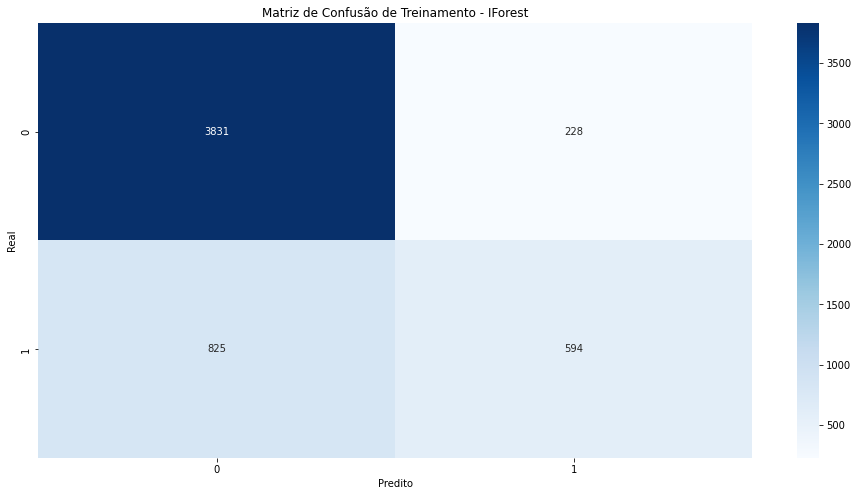

In [37]:
fig, ax = plt.subplots(figsize=(16, 8))
cm = confusion_matrix(train_labels, train_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusão de Treinamento - IForest")
plt.xlabel("Predito")
plt.ylabel('Real')
plt.show()

## Resultados nos Dados de Teste

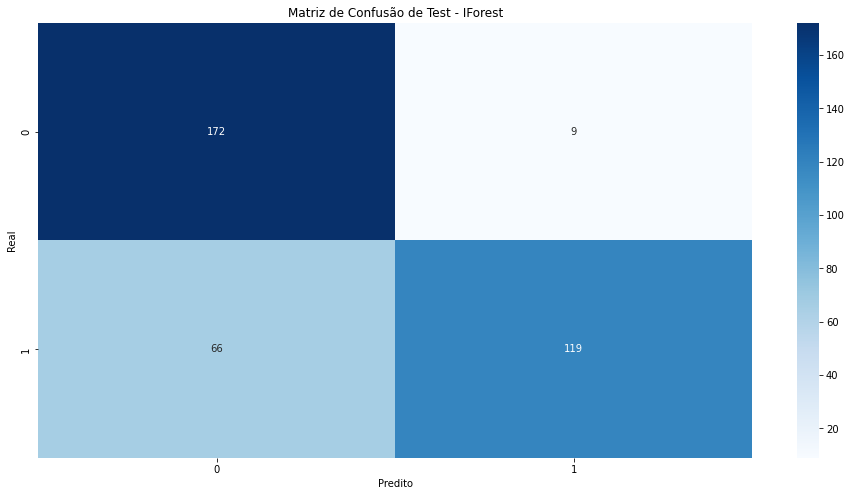

In [38]:
fig, ax = plt.subplots(figsize=(16, 8))
cm = confusion_matrix(test_labels, test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusão de Test - IForest")
plt.xlabel("Predito")
plt.ylabel('Real')
plt.show()

# Interpretação de Resultados

## Feature Importances

In [50]:
test_feature_importance_dict = OrderedDict((k, feature_importance_dict[k]) for k in test_report_df.index if k in feature_importance_dict)

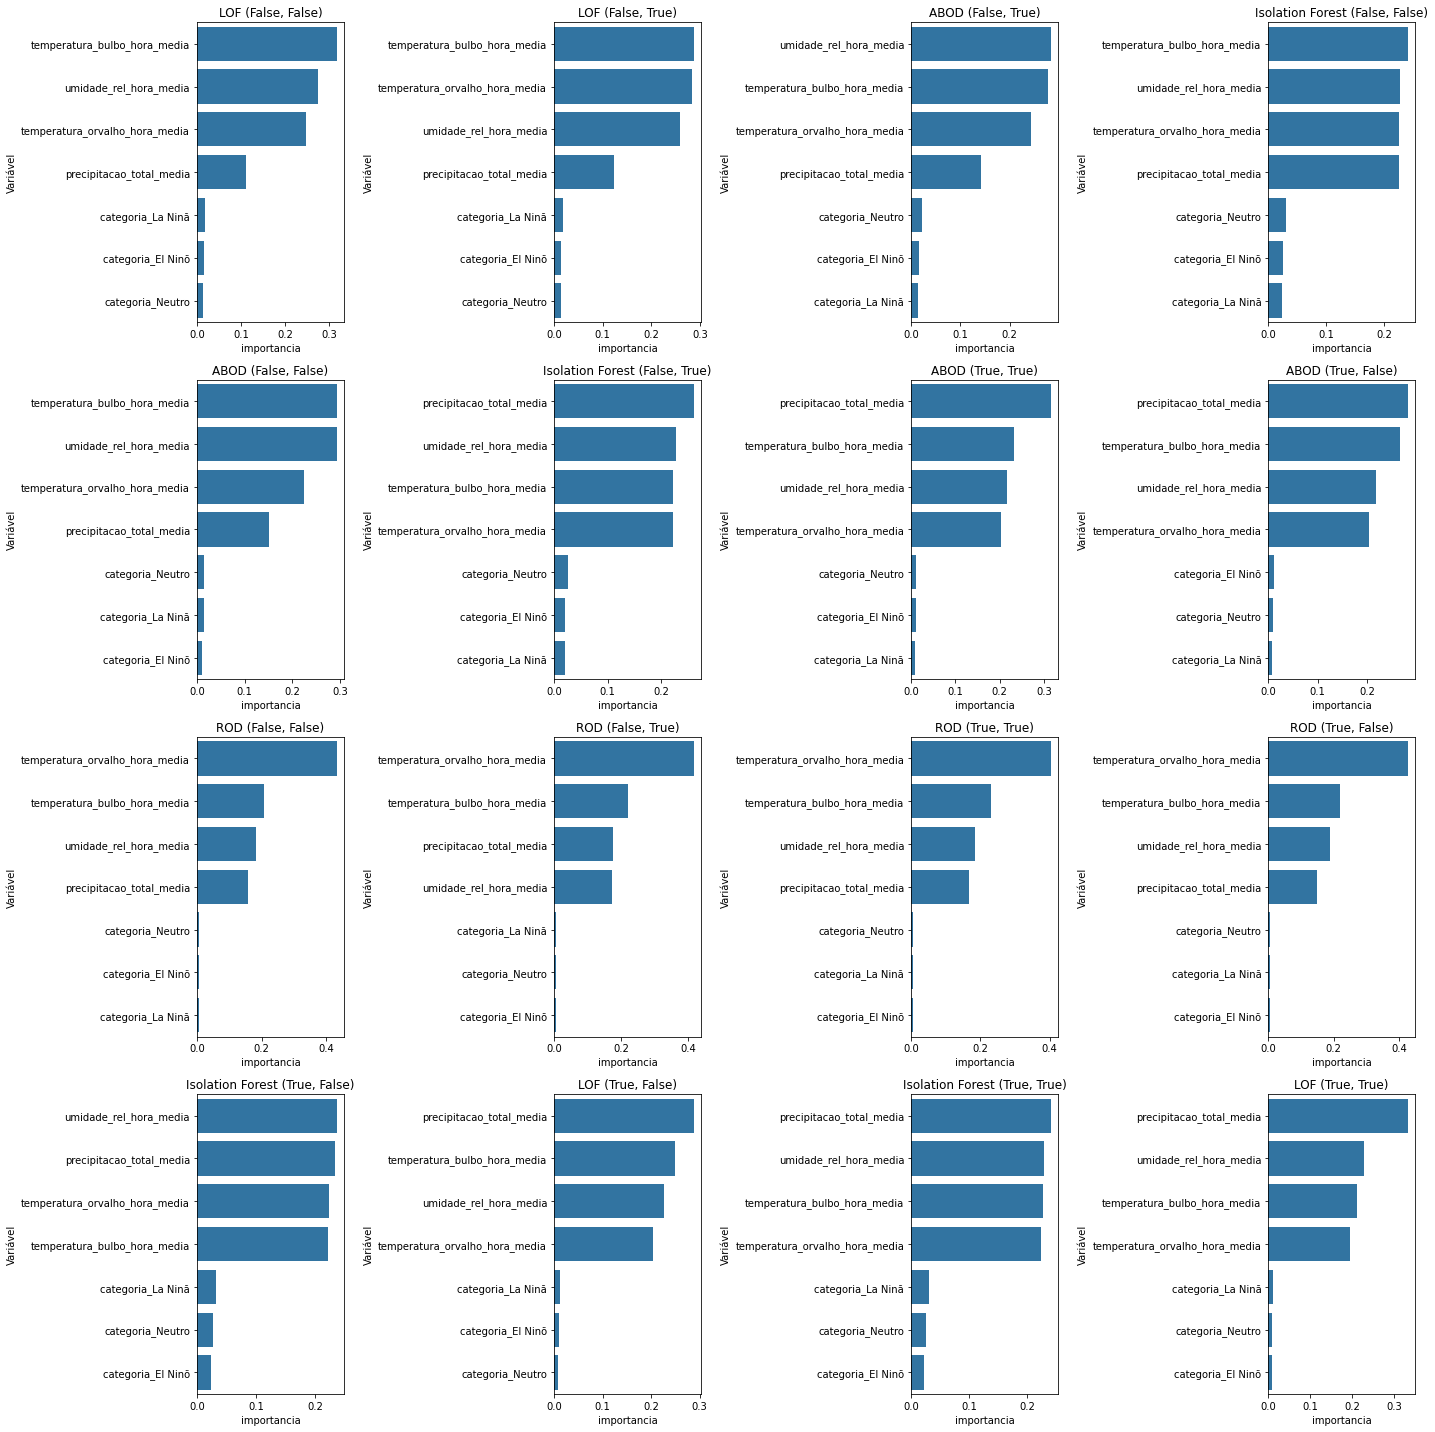

In [51]:
plot_feature_importances(feature_importance_dict=test_feature_importance_dict)

## SHAP Values

In [52]:
def predict_fn(X):
    return model.decision_function(X)

In [53]:
test_selected_models = OrderedDict((k, models_dict[k]) for k in test_report_df.index[:5] if k in models_dict)

In [ ]:
shap_values_dict = {}

for model_name, model in test_selected_models.items():
    train_data = train_data_dict[model_name][feature_cols]
    test_data = test_data_dict[model_name][feature_cols]

    try:
        print(f"Computing SHAP values for {model_name}")
        # explainer = shap.Explainer(
        #     predict_fn, 
        #     train_data.sample(int(len(train_data) * 0.1)), 
        #     algorithm="permutation")

        explainer = shap.Explainer(model.decision_function, test_data)
        shap_values = explainer(test_data)
        
        shap_values = explainer(test_data[feature_cols])
        shap_values_dict[model_name] = shap_values
    except:
        shap_values_dict[model_name] = None
        print(f"SHAP values not available for {model_name}")
        pass

Computing SHAP values for LOF (False, False)


ExactExplainer explainer: 367it [00:46,  6.78it/s]                         
ExactExplainer explainer: 367it [00:34,  8.13it/s]                         


Computing SHAP values for LOF (False, True)


ExactExplainer explainer: 367it [00:32,  8.45it/s]                         
ExactExplainer explainer: 367it [00:36,  7.12it/s]                         


Computing SHAP values for ABOD (False, True)


ExactExplainer explainer:   6%|▌         | 21/366 [00:37<11:09,  1.94s/it]

SHAP values not available for ABOD (False, True)
Computing SHAP values for Isolation Forest (False, False)


In [ ]:
def plot_shap_values(shap_values_dict: dict):

    n = len(shap_values_dict)
    n_cols = 2
    n_rows = (n + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    axes = axes.flatten() 

    for idx, (model_name, shap_values) in enumerate(shap_values_dict.items()):
        tmp_fig = plt.figure()
        shap.summary_plot(shap_values, test_data_dict[model_name][feature_cols], show=False)
        canvas = FigureCanvas(tmp_fig)
        canvas.draw()
        
        axes[idx].imshow(canvas.buffer_rgba())
        axes[idx].axis('off')
        axes[idx].set_title(model_name)

        plt.close(tmp_fig) 

    for i in range(idx + 1, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

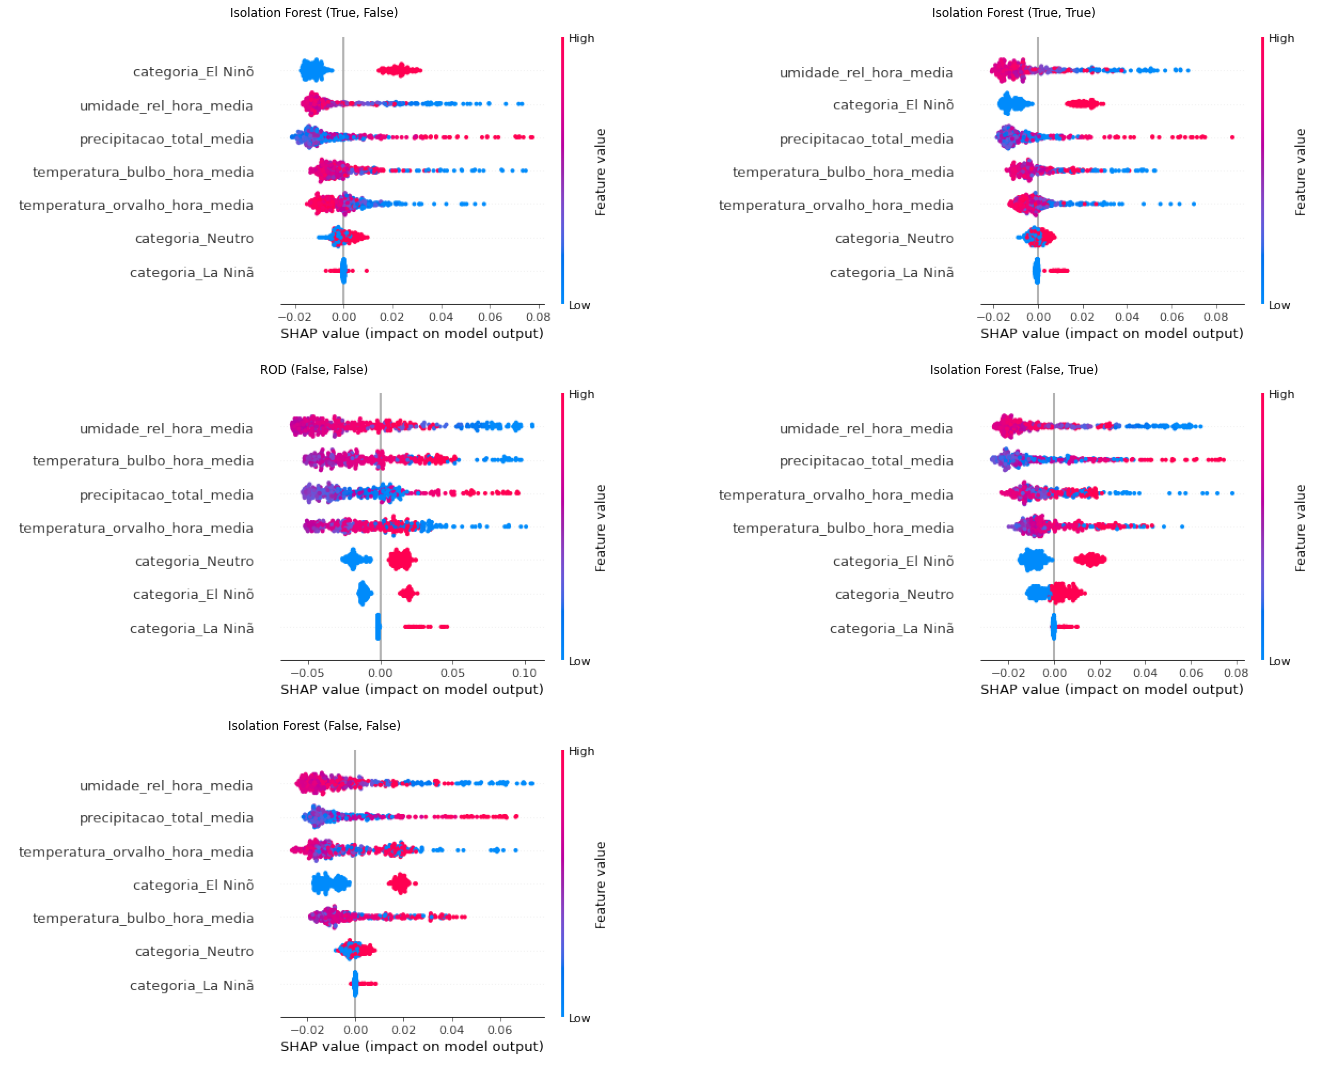

In [39]:
plot_shap_values(shap_values_dict=shap_values_dict)

## PCA

In [59]:
test_selected_data = {k:v for k,v in test_data_dict.items() if k in test_selected_models.keys()}

pca_dict = {}
for model_name, test_data in test_selected_data.items():

    pca = PCA(n_components=2)
    pca_df = pca.fit_transform(test_data[feature_cols])
    pca_df = pd.DataFrame(pca_df, columns=["PCA1", "PCA2"])
    pca_df["anomaly"] = test_data["anomaly"].values
 
    pca_dict[model_name] = pca_df

In [65]:
def plot_pca(pca_dict: dict):

    n = len(pca_dict)
    n_cols = 2
    n_rows = (n + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    axes = axes.flatten() 

    for idx, (model_name, pca_df) in enumerate(pca_dict.items()):
        sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='anomaly', palette='coolwarm', s=60, ax=axes[idx])
        axes[idx].set_xlabel('PCA1')
        axes[idx].set_ylabel('PCA2')
        axes[idx].set_title(model_name)
        axes[idx].grid(True, alpha=0.6)

    for i in range(idx + 1, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

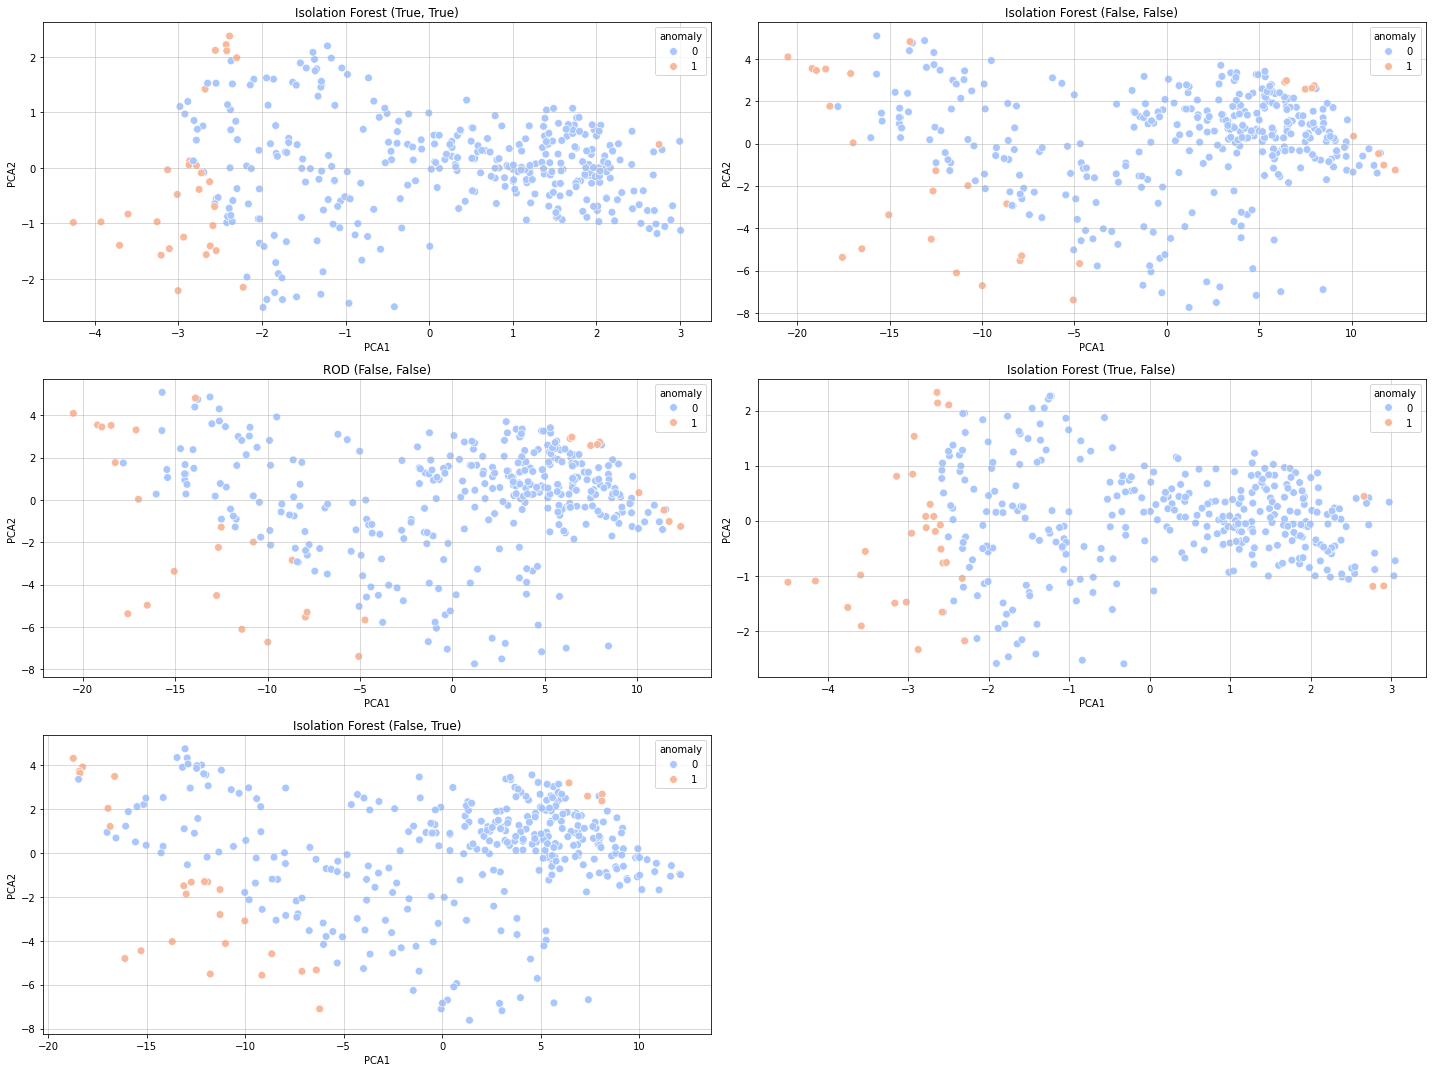

In [66]:
plot_pca(pca_dict=pca_dict)

In [125]:
def plot_decision_contours(
    test_data_dict: dict, 
    model_dict: dict,
    feature_cols: list[str]):

    """
    Cria um grid 2x2 de plots de decisão (contour plots) usando modelos e dados fornecidos.

    Args:
        test_data_dict (dict): dicionário no formato {nome_modelo: X_test (array ou DataFrame)}
        model_dict (dict): dicionário no formato {nome_modelo: modelo treinado}
    """

    n = len(test_data_dict)
    n_cols = 2
    n_rows = (n + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    axes = axes.flatten()

    for idx, (model_name, X_test) in enumerate(test_data_dict.items()):
        modelo = model_dict[model_name]

        y_test_pred = X_test["anomaly"].values

        # 2. Reduzir apenas X_test para 2D (PCA)
        pca = PCA(n_components=2)
        X_test_reduced = pca.fit_transform(X_test[feature_cols])

        # 3. Criar grid no espaço reduzido
        x_min, x_max = X_test_reduced[:, 0].min() - 1, X_test_reduced[:, 0].max() + 1
        y_min, y_max = X_test_reduced[:, 1].min() - 1, X_test_reduced[:, 1].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                             np.linspace(y_min, y_max, 300))
        grid_reduced = np.c_[xx.ravel(), yy.ravel()]
        
        # 4. Mapear grid para o espaço original
        grid_original = pca.inverse_transform(grid_reduced)

        # 5. Obter scores do modelo no grid
        grid_scores = modelo.decision_function(grid_original)
        grid_scores = grid_scores.reshape(xx.shape)

        ax = axes[idx]

        contour = ax.contourf(
            xx, 
            yy, 
            grid_scores, 
            levels=np.linspace(grid_scores.min(), grid_scores.max(), 50),
            cmap='coolwarm', 
            alpha=0.6)
        
        # cbar = fig.colorbar(contour, ax=ax)
        # cbar.set_label('Anomaly Score')
        
        sns.scatterplot(
            x=X_test_reduced[:, 0], 
            y=X_test_reduced[:, 1], 
            hue=y_test_pred,
            palette={0: 'blue', 1: 'red'}, 
            s=60, 
            ax=ax, 
            legend=False)

        ax.set_xlabel('PCA1')
        ax.set_ylabel('PCA2')
        ax.set_title(model_name)
        ax.grid(True, alpha=0.6)

    for i in range(idx + 1, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()


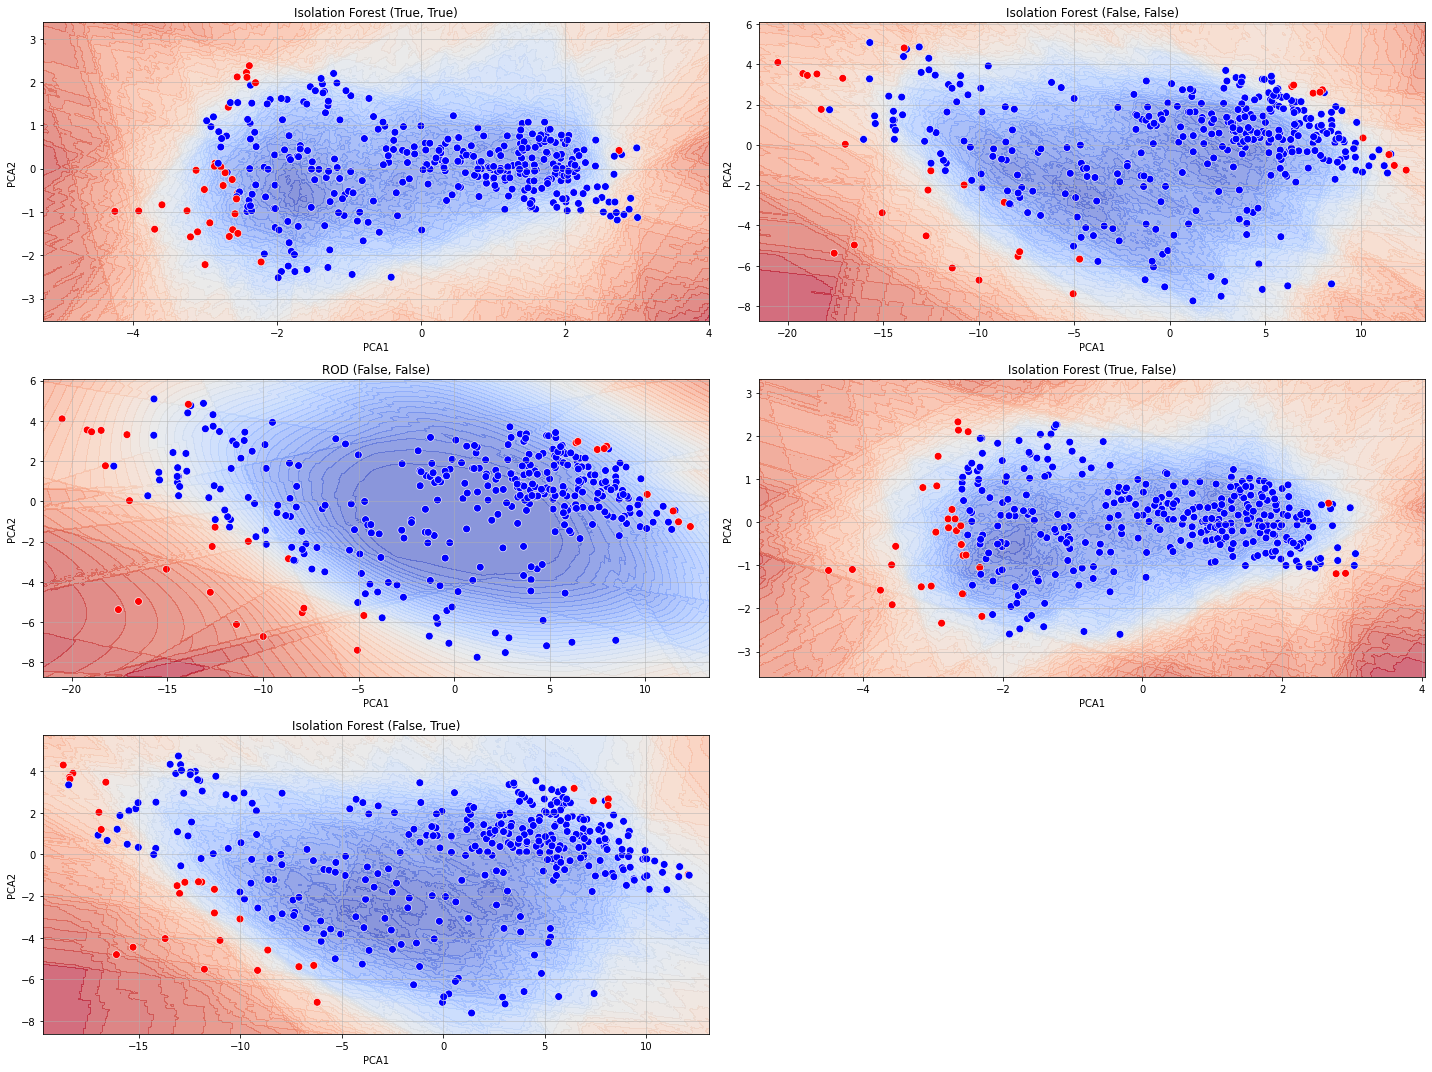

In [126]:
plot_decision_contours(
    test_data_dict=test_selected_data, 
    model_dict=test_selected_models,
    feature_cols=feature_cols)